# GradCAM Example Notebook
## "Explain Me This: Salience-Based Explainability for Synthetic Face Detection Models"
### by ****, 1/31/23

In [20]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage
from copy import deepcopy
import tensorflow as tf
import matplotlib as mpl
import pandas as pd
import json
import glob
from sklearn.utils import resample
from scipy import optimize
from scipy.optimize import brenth
import sys
import argparse
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage
#import seaborn as sns
from sklearn.utils import resample
from scipy import optimize
from scipy.optimize import brenth
import skimage.io
import skimage.filters
from random import randrange
from PIL import Image
from absl import app, flags
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from sklearn.utils import resample
from torchvision.io import read_image
import matplotlib.image as mpimg
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
#from xception.network.models import model_selection
from sklearn.utils import resample
import torchvision.transforms as transforms
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import GradCAM
from torchcam.methods import GradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
## This is used to calculate the blur amount based on a polynomial
def get_curve(max_blur,val,order=4):
    val = (1/(max_blur**(order-1)))*(val**order) # (1/max^3)x^4
    return val

def show_heatmap(img,stacked_img):
    plt.cla()
    #stacked_img *= (255.0/stacked_img.max()) # Change to range 0 to 255
    stacked_img = gaussian_filter(stacked_img, sigma=5) # Blur boundary between different annotation density levels

    # Generate heatmap of saliency map
    hmax = sns.heatmap(stacked_img,
        alpha = 0.5,
        zorder=2,
        edgecolor="none",
        linewidths=0.0,#,)
        xticklabels=False,
        yticklabels=False,
        cbar=False,
        rasterized=True,
        cmap="jet")
    
    hmax.imshow(img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) 
    hmax.axes.get_xaxis().set_visible(False)
    hmax.axes.get_yaxis().set_visible(False)
    plt.grid(False)
    plt.tight_layout(pad=0)
    plt.title("Heatmap representation of saliency map")
    plt.show()

def blur_image(im,stacked_img,max_blur,curved):
    blurred_im = deepcopy(im) # to hold final image
    stacked_max = max(stacked_img.max(),1) # Make sure there are no 0 maxes
    #stacked_img *= (255.0/stacked_max) # transform to 0 to 255 range
    stacked_img = scipy.ndimage.gaussian_filter(stacked_img, 5) # Blur this image so no hard boundaries between different levels
    scaled_img = stacked_img/(stacked_img.max()/max_blur) # Scale image back to range 0 to sigma max so we get correct blur level

    scaled_img = np.around(scaled_img,decimals=1) # Round to one decimal place
    uniq_vals = np.unique(scaled_img)
    for scaled_val in uniq_vals: # for all possible blur levels
        blur_amount = round(max_blur - scaled_val, 1)
        if curved: # based on polynomial instead of linear
            blur_amount  = get_curve(max_blur,blur_amount,order=4)
        
        if blur_amount != 0: # if blurring required
            indices = np.where(scaled_img == scaled_val) # where this level of blur should be applied
            qwerty = scipy.ndimage.gaussian_filter(im, blur_amount)
            blurred_im[indices] = qwerty[indices] # apply that blur level to the specified pixels
    return blurred_im

## Necessary Arguments

In [6]:
parser = argparse.ArgumentParser()
# dummy argument to work in Jupyter Notebook instead of command line
parser.add_argument('-f')
parser.add_argument('-mp', '--modelPath', default="../../Models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth", type=str)
parser.add_argument('-n', '--network', default="densenet", type=str)
parser.add_argument('-d', '--dataset', default="../../Data/images/ffhq_aligned/00001.png", type=str)
parser.add_argument('-t', '--type', default="blur")
parser.add_argument('-w', '--where', default="background")
parser.add_argument('-gc', '--gradcam', default="gradcam", type=str)

args = vars(parser.parse_args())

In [7]:
device = torch.device('cpu')

## Loading in the model

In [8]:
# Load weights of single binary DesNet121 model
weights = torch.load(args["modelPath"], map_location=device)

if args["network"] == "resnet":
    im_size = 224
    model_grad_cam = models.resnet50(pretrained=True)
    model_no_grads = models.resnet50(pretrained=True)
    num_ftrs = model_grad_cam.fc.in_features
    model_grad_cam.fc = nn.Linear(num_ftrs, 2)
    num_ftrs = model_no_grads.fc.in_features
    model_no_grads.fc = nn.Linear(num_ftrs, 2)
elif args["network"] == "inception":
    im_size = 299
    model_grad_cam = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model_grad_cam.fc = nn.Linear(num_ftrs, 2)
    model_no_grads = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model_no_grads.fc.in_features
    model_no_grads.fc = nn.Linear(num_ftrs, 2)
elif args["network"] == "xception":
    im_size = 299
    model_grad_cam, *_ = model_selection(modelname='xception', num_out_classes=2)
    model_no_grads, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model_grad_cam = models.densenet121(pretrained=True)
    num_ftrs = model_grad_cam.classifier.in_features
    model_grad_cam.classifier = nn.Linear(num_ftrs, 2)

    model_no_grads = models.densenet121(pretrained=True)
    num_ftrs = model_no_grads.classifier.in_features
    model_no_grads.classifier = nn.Linear(num_ftrs, 2)
    
#target_layers = [model_grad_cam.features[-1]]

model_grad_cam.load_state_dict(weights['state_dict'])
#target_layers = [model.features[-1]]
model_grad_cam = model_grad_cam.to(device)
model_grad_cam.eval()

model_no_grads.load_state_dict(weights["state_dict"])
model_no_grads = model_no_grads.to(device)
model_no_grads.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Preprocessing

In [9]:
if args["network"] == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])


sigmoid = nn.Sigmoid()

## Blurring Level

In [10]:
sigma_max = 10 # blurring
curved = True # Use a non-linear function to calculate blur

In [13]:
image_file = args['dataset']
example_image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)

example_image = cv2.cvtColor(example_image,cv2.COLOR_BGR2RGB)
# resizing
down_points = (im_size, im_size)
example_image = cv2.resize(example_image, down_points, interpolation= cv2.INTER_LINEAR)
(example_image_red, example_image_green, example_image_blue) = cv2.split(example_image)

## Creating the GradCAM

In [14]:
image = Image.open(image_file)
input_tensor = transform(image)
image.close()
    # Generating the Grad-Cam
if args["gradcam"] == "gradcam":
    #cam_extractor = GradCAM(model_grad_cam, target_layers)
    cam_extractor = GradCAM(model_grad_cam)
elif args["gradcam"] == "gradcamPP":
    cam_extractor = GradCAMpp(model_grad_cam, target_layers)

# Preprocess your data and feed it to the model_grad_cam
out = model_grad_cam(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model_grad_cam output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

cam = to_pil_image(activation_map[0].squeeze(0)).convert('L')
cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)
cam = np.array(cam)

## Deciding Which Region to Degrade

In [15]:
if args["where"] == "background":
    stacked_img = cam
elif args["where"] == "object":
    stacked_img = 255 - cam # flips GradCAM

## Generate the Blurring

In [16]:
# each color channel must be blurred separately
blurred_image_red = blur_image(example_image_red,stacked_img,sigma_max,curved)
blurred_image_green = blur_image(example_image_green,stacked_img,sigma_max,curved) 
blurred_image_blue = blur_image(example_image_blue,stacked_img,sigma_max,curved)

# merging color channels back togther
color_blurred_image = cv2.merge((blurred_image_red,blurred_image_green,blurred_image_blue))
color_blurred_image = np.array(color_blurred_image)
color_blurred_image = Image.fromarray(color_blurred_image)

#color_blurred_image.save(save_dir)

## Showing All Degrading Types

In [36]:
cam = to_pil_image(activation_map[0].squeeze(0)).convert('L')
cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)
cam = np.array(cam)

# switching to background for display purposes
stacked_img = 255 - cam
    
blurred_image_red = blur_image(example_image_red,stacked_img,sigma_max,curved)
blurred_image_green = blur_image(example_image_green,stacked_img,sigma_max,curved) 
blurred_image_blue = blur_image(example_image_blue,stacked_img,sigma_max,curved)  

color_blurred_image_background = cv2.merge((blurred_image_red,blurred_image_green,blurred_image_blue))
color_blurred_image_background = np.array(color_blurred_image_background)
color_blurred_image_background = Image.fromarray(color_blurred_image_background)

#color_blurred_image.save(save_dir)

## Display Degraded Images

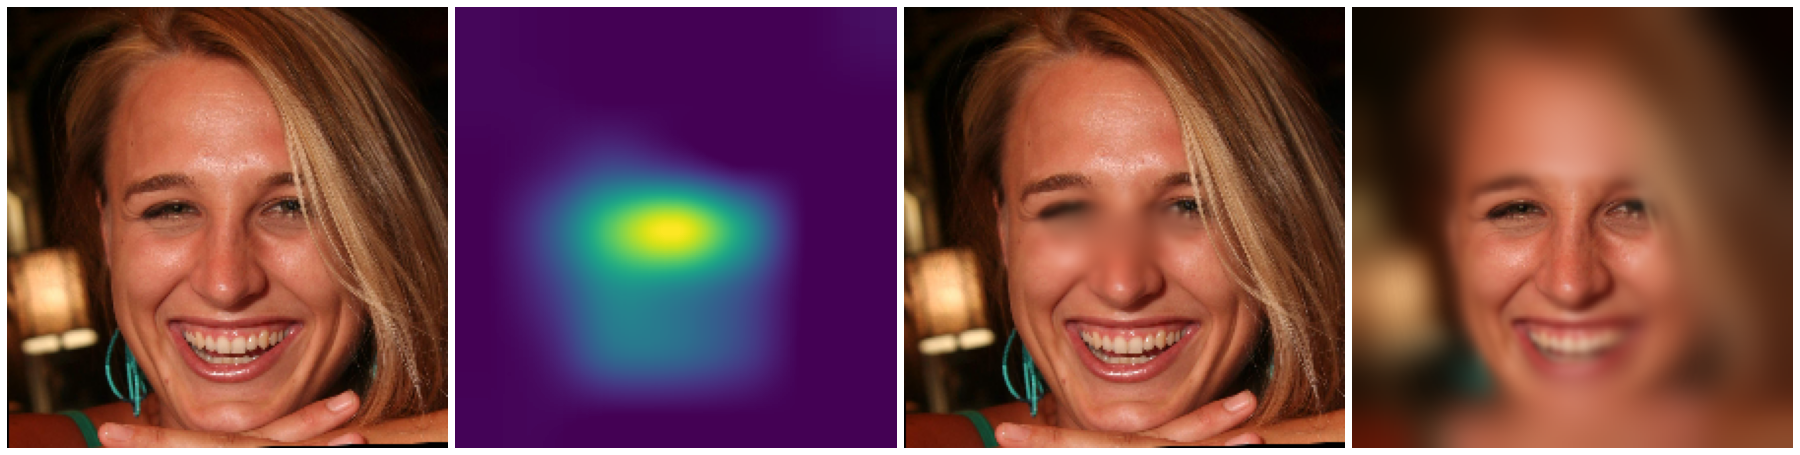

In [37]:
fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=1.2
                 )
for index, (ax, im) in enumerate(zip(grid, [example_image, cam, color_blurred_image_background, color_blurred_image])):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.grid(b=None)
    ax.imshow(im)
    #ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
#plt.savefig("entropy-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)
plt.show()